# 假设目前有一个十臂老虎机，每个手臂ai摇动一次有pi概率得到奖励为1，其余情况不得奖，现在求摇动策略使得奖励最高
 参考文献：https://hrl.boyuai.com/chapter/1/%E5%A4%9A%E8%87%82%E8%80%81%E8%99%8E%E6%9C%BA#25-%E4%B8%8A%E7%BD%AE%E4%BF%A1%E7%95%8C%E7%AE%97%E6%B3%95

## 一、建立老虎机模型

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
class Bandit:
    def __init__(self,k):
        self.probs=np.random.uniform(size=k)
        self.best_arm=np.argmax(self.probs)
        self.max_prob=self.probs[self.best_arm]
        self.k=k
        
    def step(self,a):
        if np.random.rand()<self.probs[a]:
            return 1
        else:
            return 0

np.random.seed(1)
k=10
machine=Bandit(k)
# 获奖最大概率的arm
print(machine.best_arm)
# 最大获奖概率
print(machine.max_prob)
print(machine.probs)

1
0.7203244934421581
[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01]


## 二、写出老虎机的基础操作，包括累计奖励，累计懊悔

In [27]:
class Solver:
    #自身属性，包括每根拉杆的拉动次数，动作合集，累计懊悔合集
    def __init__(self,bandit):
        self.bandit=bandit
        self.counts=np.zeros(self.bandit.k)
        self.regret=0
        self.action=[]
        self.regrets=[]
    #更新累计懊悔    
    def update_regret(self,a):
        self.regret+=self.bandit.max_prob-self.bandit.probs[a]
        self.regrets.append(self.regret)
     # 返回当次执行的动作，根据选择的算法完善   
    def run_one_step(self):
        raise NotImplementedError
    # 执行num_steps动作
    def run(self,num_steps):
        for _ in range(num_steps):
            a=self.run_one_step()
            self.update_regret(a)
            self.action.append(a)
            self.counts[a]+=1

## 三、贪婪算法

In [28]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.k)
    plt.legend()
    plt.show()

In [36]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像，包括线性时间和对数时间两种视图"""
    
    # 创建包含两个子图的画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 第一张图：线性时间尺度
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        ax1.plot(time_list, solver.regrets, label=solver_names[idx])
    ax1.set_xlabel('Time steps')
    ax1.set_ylabel('Cumulative regrets')
    ax1.set_title('Cumulative Regrets vs Time Steps\n(%d-armed bandit)' % solvers[0].bandit.k)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 第二张图：对数时间尺度
    for idx, solver in enumerate(solvers):
        # 使用对数时间尺度，避免log(0)的问题
        time_list = range(1, len(solver.regrets) + 1)  # 从1开始
        log_time = np.log(time_list)
        ax2.plot(log_time, solver.regrets, label=solver_names[idx])
    ax2.set_xlabel('Log(Time steps)')
    ax2.set_ylabel('Cumulative regrets')
    ax2.set_title('Cumulative Regrets vs Log Time\n(%d-armed bandit)' % solvers[0].bandit.k)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [12]:
class EpsilonGreedy(Solver):
    def __init__(self,bandit,epsilon=0.01,init_prob=1.0):
        super().__init__(bandit)
        self.epsilon=epsilon
        self.estimates=np.array([init_prob]*self.bandit.k)
        
    def run_one_step(self):
        if np.random.random()<self.epsilon:
            a=np.random.randint(0,self.bandit.k)
        else:
            a=self.bandit.best_arm
        reward=self.bandit.step(a)
        self.estimates[a]+=(reward-self.estimates[a])/(1+self.counts[a])
        return a

40.076833988594


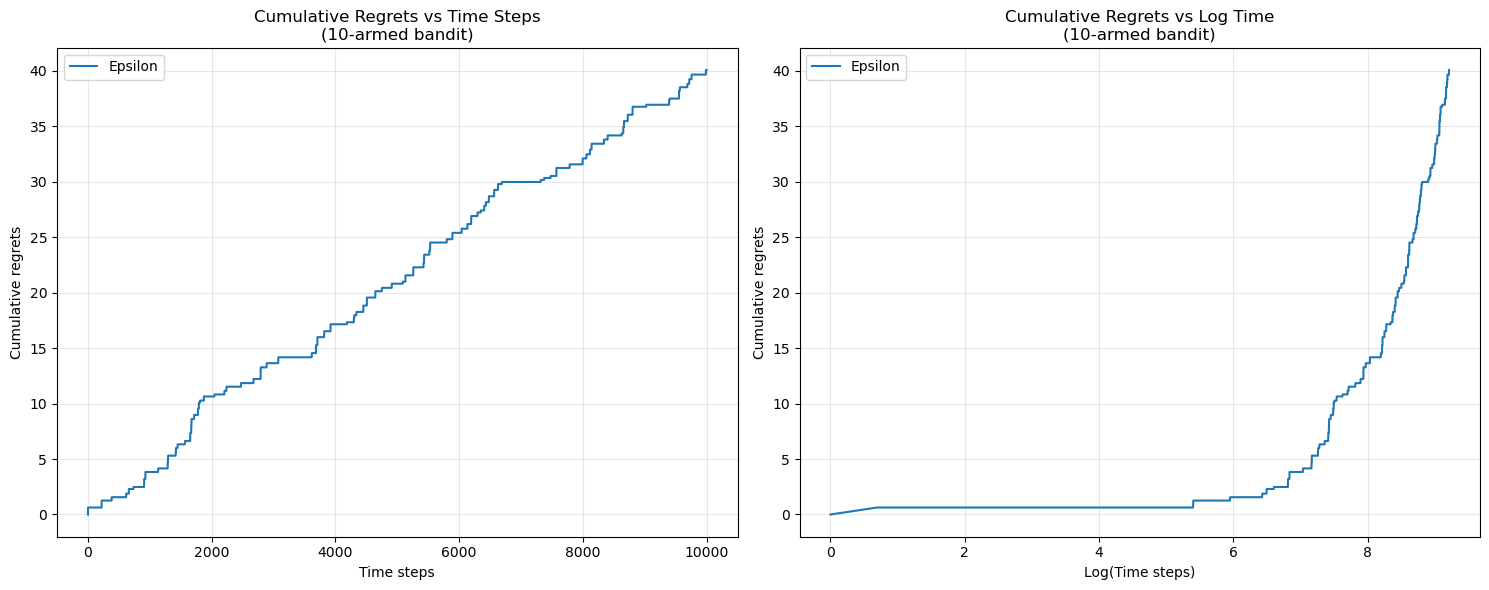

In [50]:
np.random.seed(1)
solver=EpsilonGreedy(machine,epsilon=0.01)
solver.run(10000)
print(solver.regret)
plot_results([solver],["Epsilon"])

## 衰减贪婪算法

In [60]:
class DeclineEpsilon(Solver):
    def __init__(self,bandit,total_num=0,init_prob=1.0):
        # self.bandit=bandit
        super().__init__(bandit)
        self.total_num=0
        self.estimates=np.array([1.0]*self.bandit.k)
        
    def run_one_step(self):
        self.total_num+=1
        epsilon=1/(self.total_num)
        if np.random.random()<epsilon:
            a=np.random.randint(0,self.bandit.k)
        else:
            a=np.argmax(self.estimates)
        reward=self.bandit.step(a)
        self.estimates[a]+=(reward-self.estimates[a])/(1+self.counts[a])
        return a        

[0.33333333 0.72277683 0.         0.33333333 0.         0.33333333
 0.5        0.         0.5        0.66666667]
12.422395926525834


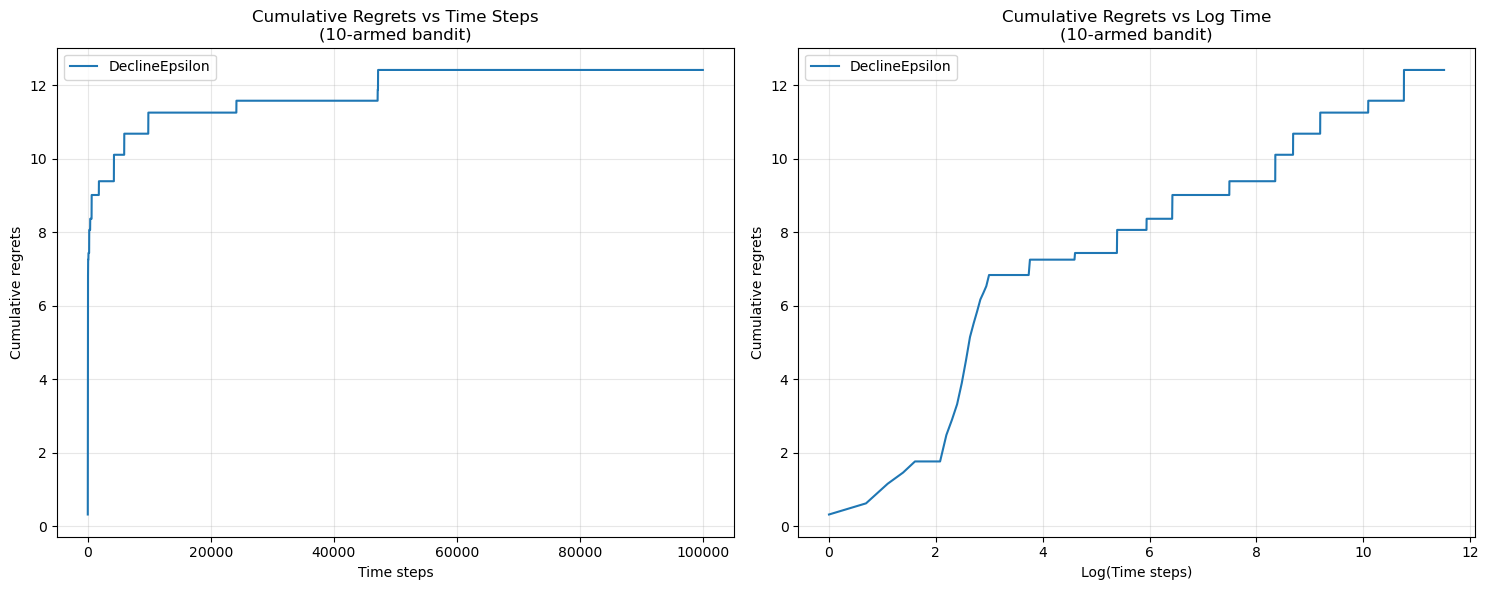

In [64]:
np.random.seed(1)
solver=DeclineEpsilon(machine)
solver.run(100000)
print(solver.estimates)
print(solver.regret)
plot_results([solver],["DeclineEpsilon"])

## 四、上界置信算法

[0.46428571 0.72004818 0.         0.07692308 0.25925926 0.07692308
 0.16666667 0.22727273 0.32432432 0.5248227 ]
117.1857378941749


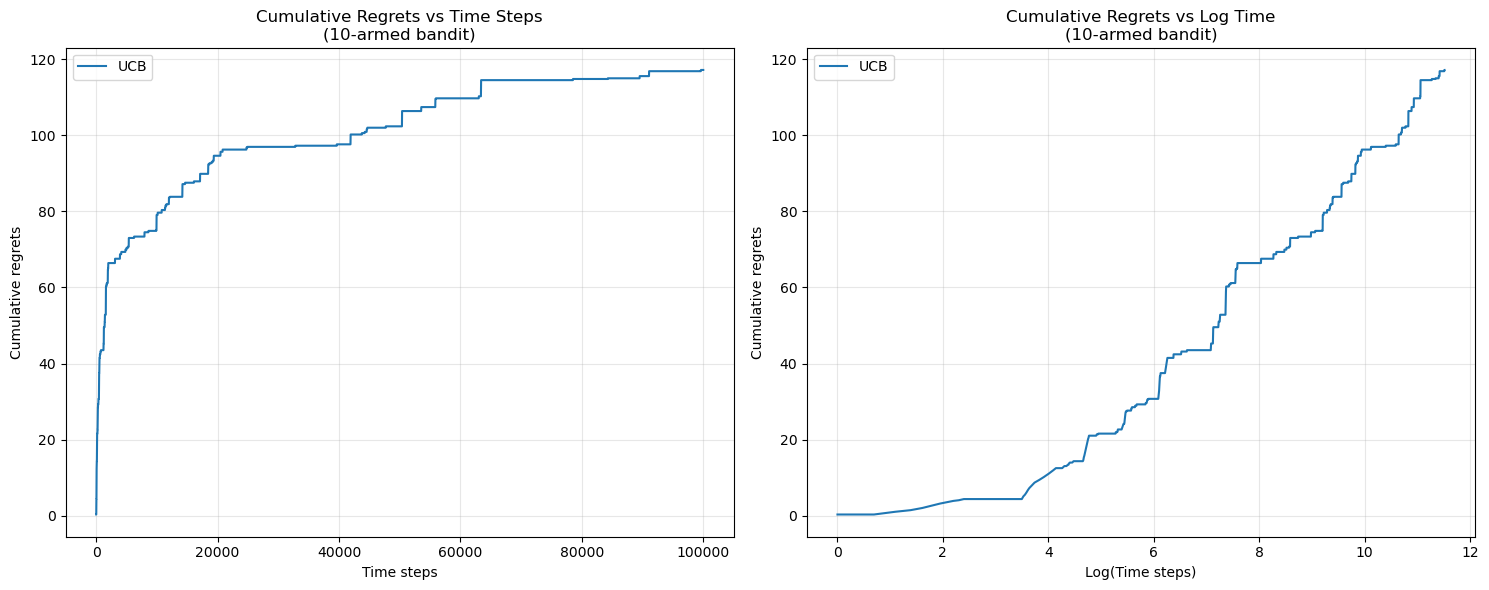

In [52]:
class UCB(Solver):
    def __init__(self,bandit,coef):
        super().__init__(bandit)
        self.coef=coef
        self.estimates=np.array([0.0]*self.bandit.k)
        self.total_num=0
        
    def run_one_step(self):
        self.total_num+=1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_num) / (2 * (self.counts + 1)))  # 计算上置信界
        a=np.argmax(ucb)
        reward=self.bandit.step(a)
        self.estimates[a]+=(reward-self.estimates[a])/(1+self.counts[a])        
        return a
    
np.random.seed(1)
coef=1.0
solver=UCB(machine,coef)
solver.run(100000)
print(solver.estimates)
print(solver.regret)
plot_results([solver],["UCB"])     

## 五、采样算法

[0.5        0.72886937 0.25       0.2        0.33333333 0.28571429
 0.2        0.38461538 0.44444444 0.54545455]
32.71499203639502


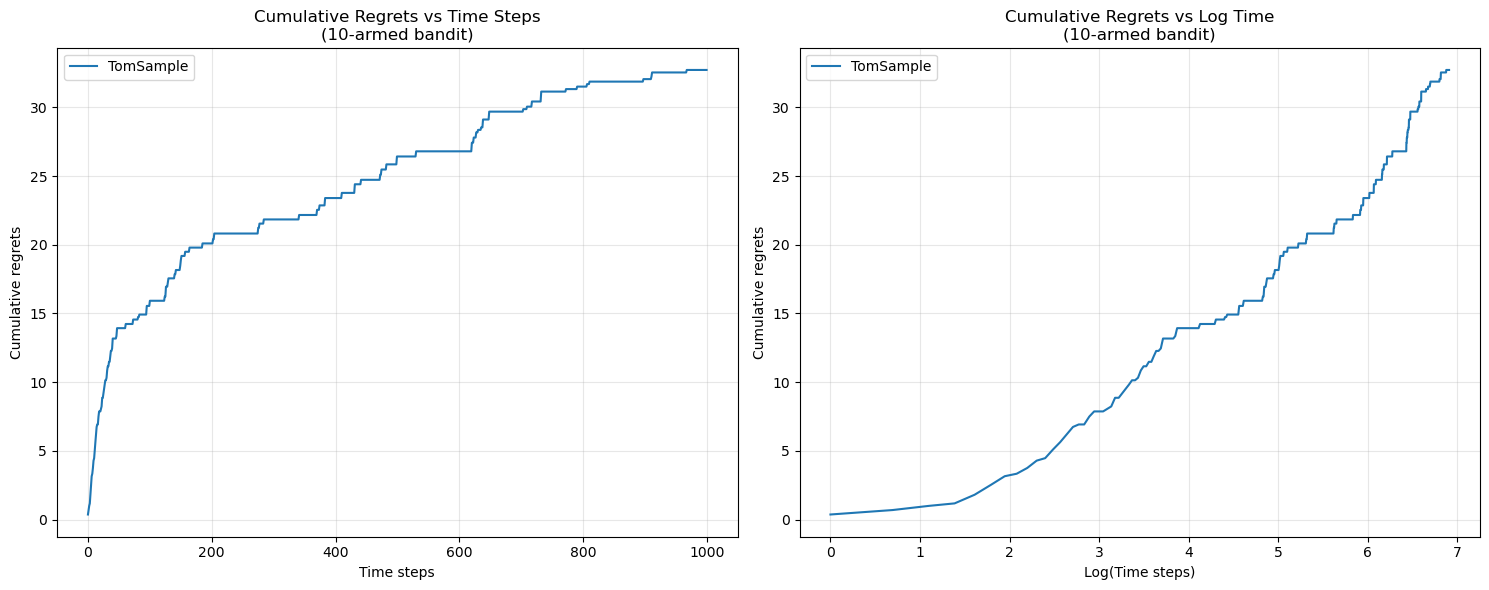

In [70]:
class Sampling(Solver):
    def __init__(self,bandit):
        super().__init__(bandit)
        self._a=np.ones(self.bandit.k)# 1
        self._b=np.ones(self.bandit.k)# 0
    
    def run_one_step(self):
        samples=np.random.beta(self._a,self._b)
        a=np.argmax(samples)
        reward=self.bandit.step(a)
        self._a[a]+=reward
        self._b[a]+=(1-reward)
        return a

np.random.seed(1)
solver=Sampling(machine)
solver.run(1000)
print(solver._a/solver.counts)
print(solver.regret)
plot_results([solver],["TomSample"])    

# 总结

## 由图可知，采样算法跟UCB算法，都可以得到对数线性的累计懊悔曲线，固定贪婪算法得到的则是线性对数曲线
## 在实际情况下，可以通过调整UCB算法的位置奖励系数与衰减贪婪算法的epsilon来调整策略